# 模型所用的工具包

In [3]:
import copy
import torch
import torch.nn as nn
import time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np

## Encoder/Decoder block实现

In [4]:
# https://zhuanlan.zhihu.com/p/75206669
# https://blog.csdn.net/qq_38863413/article/details/104118055
def clones(module, N):
    """
    module：输入模型(也就是 encoder block)
    N： 重复次数(block 个数)
    """
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

## 归一化Norm层

In [5]:
# https://zhuanlan.zhihu.com/p/368808794
# https://blog.csdn.net/xinjieyuan/article/details/109587913
class LayerNorm(nn.Module):
    def __init__(self, feature_size, eps=1e-6):
        """
        归一化层，使用的归一化方法并不唯一
        feature_size: 输入的特征的尺寸
        eps：一个足够小的数防止分母为 0 的
        """
        super(LayerNorm, self).__init__()
        '''
        这里的 a2 和 b2 可以类比成 weight 和 bais，nn.Parameter的处理可以理解为让该参数注册进网络实现可优化的目的，注意维度要可以相乘
        '''
        self.a_2 = nn.Parameter(torch.ones(feature_size))
        self.b_2 = nn.Parameter(torch.zeros(feature_size))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

## Add & Norm 实现

In [6]:
# https://zhuanlan.zhihu.com/p/651641664 dropout 解释
class SublayerConnection(nn.Module):
    def __init__(self, feature_size, dropout):
        """
        残差连接模块，对应论文的 Add & Norm
        :param feature_size: (int)模型尺寸
        :param dropout: (int)丢弃机制
        """
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(feature_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer_func):
        """
        前向传播，将输入与正则化的输出相加； 先对输入标准化处理后再代入子层处理函数，然后dropout后再得到残差连接结果
        :param x: 上层或者子层的输入
        :param sublayer_func: 该子层中的子层函数
        :return: relu残差输出
        """
        return x + self.dropout(sublayer_func(self.norm(x)))

In [7]:
# 部分参数还未搞懂
def run_epoch(data_iter, model, loss_compute):
    """
    通用的训练和评分函数来跟踪损失。传入一个通用的损失计算函数处理参数更新。
    :param data_iter: 迭代数据
    :param model: 输入的模型
    :param loss_compute:损失计算
    :return:
    """
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        model_out = model.forward(batch.input_embed, batch.target_embed, batch.input_mask, batch.target_mask)
        loss = loss_compute(model_out, batch.target_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        # 判断是为了每 50次输出一次结果
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" % (i, loss / batch.ntokens, tokens / elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

## 学习率更新(动态更新学习率)

In [8]:
# https://zhuanlan.zhihu.com/p/60821628
# https://zhuanlan.zhihu.com/p/466992867
class NoamOpt:
    def __init__(self, model_size, factor, warmup, optimizer):
        """
        优化器：论文用的是adam，这个类主要用于针对不同模型尺寸动态更新学习率
        transformer 中的学习率更新公式叫 noam
        :param model_size:
        :param factor:
        :param warmup: 热身步数，比照参考链接中的图指的是直线部分
        :param optimizer:优化器
        """
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0

    def step(self):
        # 更新参数和学习率
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        # 更新优化器参数(更新完优化器后再更新学习率)
        self.optimizer.step()

    def rate(self, step=None):
        # 执行上面更新的学习率
        if step is None:
            step = self._step
        return self.factor * (self.model_size ** (-0.5) * min(step ** (-0.5), step * self.warmup ** (-1.5)))

In [9]:
def get_std_opt(model):
    """
    优化器调用示例：
    :param model:
    :return:
    """
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
                   torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

## 标签平滑

In [10]:
# 没看懂。。
class LabelSmoothing(nn.Module):
    def __init__(self, size, padding_idx, smoothing=0.0):
        """
        标签平滑:论文正则化的一种方式，另外就是使用dropout了
        在训练期间，使用values的标签平滑，使用 KL div 损失实现标签平滑，防止模型过度自信预测
        论文没有使用 one-hot 目标分布，而是创建了一个分布，该分布具有confidence正确的单词和分布在整个词汇表中的其余smoothing。
        :param size: (int) 模型尺寸，对应词向量长度
        :param padding_idx: (int) 填充步幅
        :param smoothing:
        """
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None

    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1).long(), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

## 测试

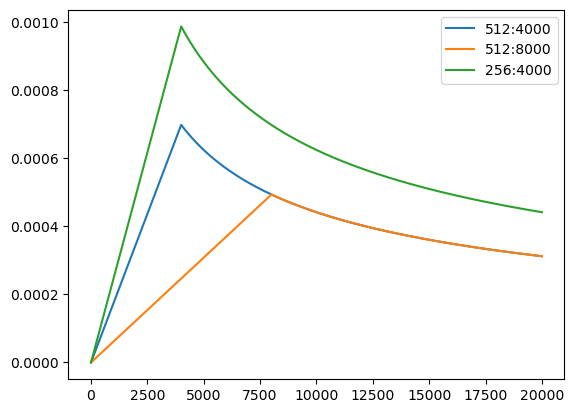

In [11]:
# 针对不同模型大小和优化超参数的曲线示例。
# 设置三个不同的模型尺寸，最大学习率上升步阈值(model_size, factor, warmup, optimizer):
opts = [NoamOpt(512, 1, 4000, None),
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])
plt.show()

tensor([[   -inf, -1.6094, -0.3567, -2.3026,    -inf],
        [   -inf, -1.6094, -0.3567, -2.3026,    -inf],
        [   -inf, -1.6094, -0.3567, -2.3026,    -inf]])
tensor([[0.0000, 0.1333, 0.6000, 0.1333, 0.1333],
        [0.0000, 0.6000, 0.1333, 0.1333, 0.1333],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])


/Users/gedun/anaconda3/envs/nlp_test/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


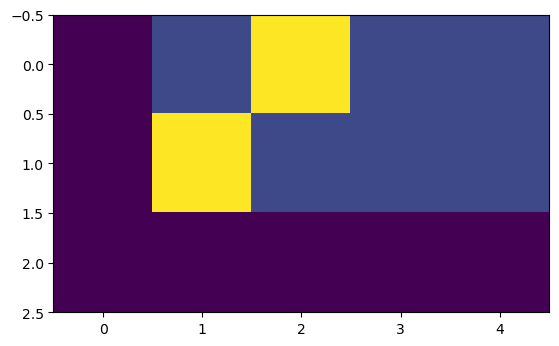

predict: tensor([[0.0000, 0.2500, 0.2500, 0.2500, 0.2500]])
predict: tensor([[0.0000, 0.4000, 0.2000, 0.2000, 0.2000]])
predict: tensor([[0.0000, 0.5000, 0.1667, 0.1667, 0.1667]])
predict: tensor([[0.0000, 0.5714, 0.1429, 0.1429, 0.1429]])
predict: tensor([[0.0000, 0.6250, 0.1250, 0.1250, 0.1250]])
predict: tensor([[0.0000, 0.6667, 0.1111, 0.1111, 0.1111]])
predict: tensor([[0.0000, 0.7000, 0.1000, 0.1000, 0.1000]])
predict: tensor([[0.0000, 0.7273, 0.0909, 0.0909, 0.0909]])
predict: tensor([[0.0000, 0.7500, 0.0833, 0.0833, 0.0833]])
predict: tensor([[0.0000, 0.7692, 0.0769, 0.0769, 0.0769]])
predict: tensor([[0.0000, 0.7857, 0.0714, 0.0714, 0.0714]])
predict: tensor([[0.0000, 0.8000, 0.0667, 0.0667, 0.0667]])
predict: tensor([[0.0000, 0.8125, 0.0625, 0.0625, 0.0625]])
predict: tensor([[0.0000, 0.8235, 0.0588, 0.0588, 0.0588]])
predict: tensor([[0.0000, 0.8333, 0.0556, 0.0556, 0.0556]])
predict: tensor([[0.0000, 0.8421, 0.0526, 0.0526, 0.0526]])
predict: tensor([[0.0000, 0.8500, 0.0500

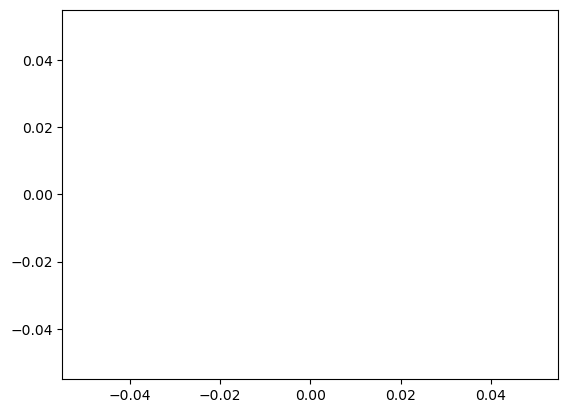

In [13]:
# 测试 label smoothing.(size, padding_idx, smoothing=0.0):
crit = LabelSmoothing(5, 0, 0.4)
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0]])
v = crit(Variable(predict.log()), Variable(torch.LongTensor([2, 1, 0])))
print(predict.log())
print(crit.true_dist)
# 显示系统预期的目标分布.
plt.imshow(crit.true_dist)
plt.show()

# 标签平滑实际上开始惩罚模型，如果它对给定的选择非常自信。
crit = LabelSmoothing(5, 0, 0.1)
def loss(x):
    d = x + 3 * 1
    predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d], ])
    print("predict:", predict)
    return crit(Variable(predict.log()), Variable(torch.LongTensor([1]))).item()
plt.plot(np.arange(1, 100), [loss(x) for x in range(1, 100)])
plt.show()